# One dimension experiment

This is a 1D experiment for the trial HF function 
\begin{align}
f^{HF}(x) = \exp(2-\sin(1)x),
\end{align}
and trial LF function
\begin{align}
f^{LF}(x) = \sum_{n=0}^3\frac{(2-\sin(1)x)^n}{n!}.
\end{align}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys 
sys.path.append('../')
import models
import math

In [2]:
# the element function
def element(xi):
    vec = torch.sin(torch.Tensor([1.0]))
    return (2 - vec * xi).squeeze(1)

# the finite sum function
def finite_sum(xi, M):
    res  = torch.zeros(len(xi))
    elem = element(xi)
    for m in range(M+1):
        res += elem ** m/math.factorial(m)
    return res

# LF evaluation function
def f_LF(xi):
    M = 3
    return finite_sum(xi, M)

# HF evaluation function
def f_HF(xi):
    elem = element(xi)
    return elem.exp()

# sampling x by p(x)
def sample_p(N):
    return torch.rand(N, 1)

As $q(x)$ is 
\begin{align}
q(x) \propto \frac{(f^{LF}(x) - \mu^{LF})^2}{2\ell^2}
\end{align}

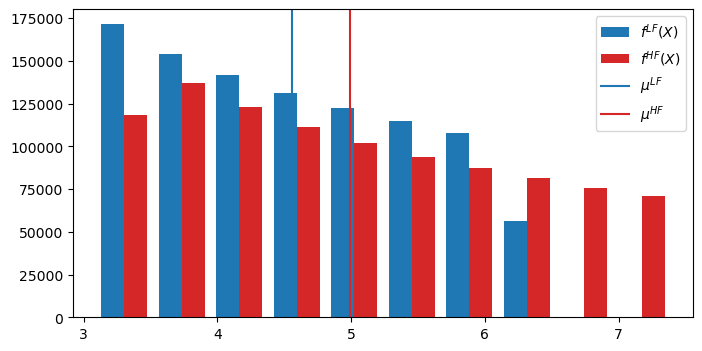

In [3]:
# evaluate ExL and ExH
x   = sample_p(int(1e6))
xL = f_LF(x)
xH = f_HF(x)
ExL = xL.mean().item()
ExH = xH.mean().item()
SxL = xL.std().item()
SxH = xH.std().item()

bound = torch.tensor([0, 1]) # range of inputs

# plot histograms of xL and xH
plt.figure(figsize=(8,4))
plt.hist([xL,xH],label=[r'$f^{LF}(X)$',r'$f^{HF}(X)$'],color=['tab:blue','tab:red'])
plt.axvline(x = ExL, color = 'tab:blue', label = r'$\mu^{LF}$')
plt.axvline(x = ExH, color = 'tab:red', label = r'$\mu^{HF}$')
plt.legend()

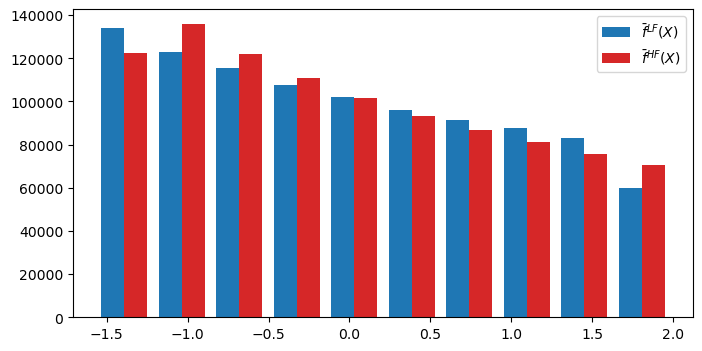

In [4]:
# plot histograms of normalized xL and xH
n_xL = (xL - ExL)/SxL
n_xH = (xH - ExH)/SxH

plt.figure(figsize=(8,4))
plt.hist([n_xL, n_xH],label=[r'$\bar{f}^{LF}(X)$',r'$\bar{f}^{HF}(X)$'],color=['tab:blue','tab:red'])
plt.legend()

In [5]:
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz

# plot biasing density q(x)
ell = 0.2
def q(x):
    return torch.exp(-((f_LF(x) - ExL)**2/(2 * ell**2)))

def get_inverted_cdf(xs, pdfs):
    cdfs = cumtrapz(pdfs, x=xs) # Get the CDF using a very fast trapz rule
    cdfs = cdfs / cdfs.max()  # Ensure its normalised, to cater for unnormalised PDFs
    cdfs = np.insert(cdfs, 0, 0)  # Add the 0 area to start of the CDF array
    return interp1d(cdfs, xs, kind="linear")  # return interpolation from cdf -> x
    
def sample_fn(fn, n=1):
    return fn(np.random.random(size=n))

In [6]:
xs = torch.linspace(0.0, 1.0, 1000).unsqueeze(1)
pdfs = q(xs).detach().numpy()
xs = xs.squeeze().detach().numpy()
fn = get_inverted_cdf(xs, pdfs)
q_smps_1 = sample_fn(fn, n=100000)

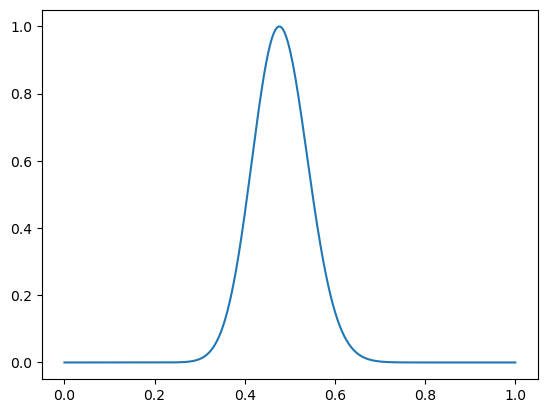

In [7]:
plt.plot(xs, pdfs, label='q(x)')

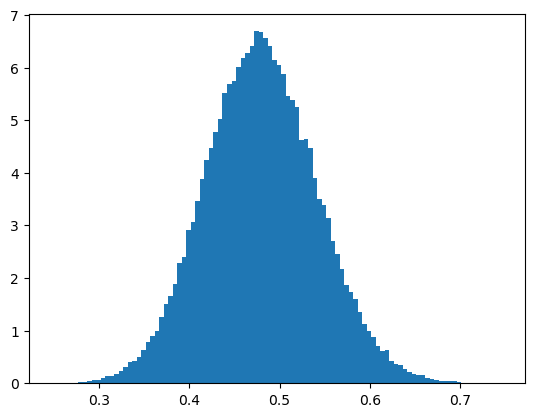

In [8]:
_ = plt.hist(q_smps_1, bins=100, density=True, label='q(x)')

In [9]:
# apply Langevin algorithm to sample from q(x)
from tqdm import tqdm
def potential(z,ell): # evaluate the potential function for the given z
    return (f_LF(z)-ExL)**2/(2*ell**2)

def unadjusted_langevin_algorithm(potential, iter_num=int(1e4), step=1e-2, burn_in=int(1e6)):
    Z0 = sample_p(1)
    Zi = Z0
    samples = []
    for i in tqdm(range(iter_num + burn_in)):
        Zi.requires_grad_()
        u = potential(Zi,ell).mean()
        grad = torch.autograd.grad(u, Zi)[0]
        rejected = True
        new_step = np.copy(step)
        count = 0
        while rejected:
            new_Zi = Zi.detach() - new_step * ell**2 * grad + np.sqrt(2 * new_step * ell**2) * torch.randn(1)
            if (new_Zi < 1).all() and (new_Zi > 0).all():
                Zi = new_Zi
                rejected = False
                count += 1
            if count > 10:
                new_step /= 2
        samples.append(Zi.detach())
    return torch.cat(samples, 0)[burn_in:]

In [19]:
q_smps_2 = unadjusted_langevin_algorithm(potential, iter_num=int(1e5), step=1e-3, burn_in=int(1e6)).squeeze().detach().numpy()

100%|██████████| 1100000/1100000 [04:43<00:00, 3885.83it/s]


Text(0.5, 1.0, 'Langevin algorithm')

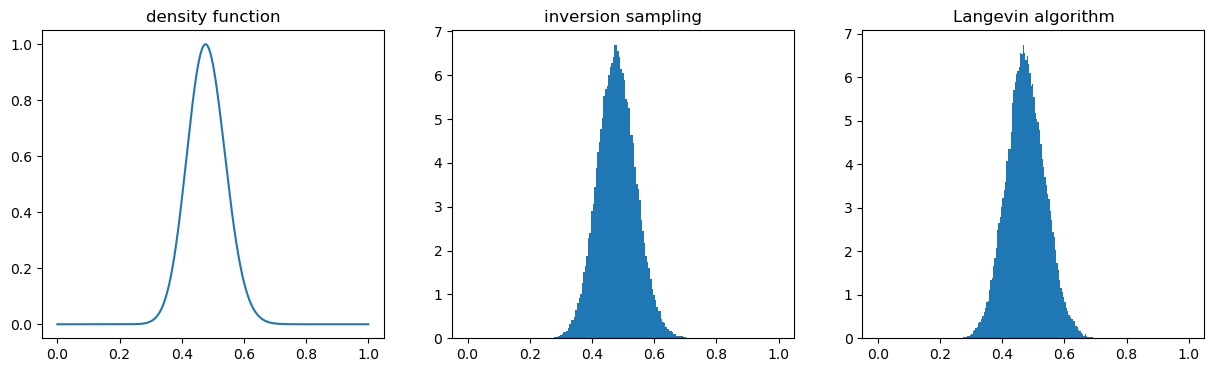

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharex=True)
axs[0].plot(xs, pdfs)
axs[0].set_title('density function')
axs[1].hist(q_smps_1, bins=100, density=True)
axs[1].set_title('inversion sampling')
axs[2].hist(q_smps_2, bins=100, density=True)
axs[2].set_title('Langevin algorithm')
# fig.savefig('dim-1.png', dpi=200)

In [21]:
def weight(xi): # evaluate the unnormalized weight for the given xi
    wt = ((f_LF(xi) - ExL).square()/(2*ell**2)).exp()
    return wt

def control_variate(xi):
    N_LF = 1000
    

In [25]:
x_q_lst = q_smps_2.reshape(100000, 1)

We implement three different estimators:

- **Monte Carlo estimator**
\begin{align*}
\hat{X}^\text{MC}_N = \frac{1}{N}\sum_{i=1}^N f^\text{HF}(X_i).
\end{align*}

- **L-BF-IS estimator**
\begin{align*}
\hat{X}^\text{BF}_N = \frac{1}{N}\sum_{i=1}^N f^\text{HF}(Y_i)\frac{\hat{w}_i(Y_i)}{\sum \hat{w}_i(Y_i)},
\end{align*}
where $Y_i$ are *i.i.d.* samples from biasing distribution $q(x)$.

- **Monte Carlo estimator**
\begin{align*}
\hat{X}^\text{CV}_N = \frac{1}{N}\sum_{i=1}^N f^\text{HF}(X_i) - \eta (f^\text{LF}(X_i) - \mu^\text{LF}),
\end{align*}
where the control variate coefficient $\eta$ is
\begin{align*}
\eta = \frac{\text{cov}(f^\text{LF}(X), f^\text{HF}(X))}{\text{Var}(f^\text{LF}(X))}.
\end{align*}

In [26]:
MC_N_lst = (10**np.linspace(0, 4, 10)).astype('int')
MC = []
IS = []
wt = []
num_trial = 100
for j in range(num_trial):
    MC_est_lst = []
    IS_est_lst = []
    wt_lst     = []
    for MC_N in MC_N_lst:
        xi_p = sample_p(MC_N) # sample MC xi_p
        xi_q = x_q_lst[np.random.choice(len(x_q_lst),MC_N)] # sample xi_q
        wt_q = weight(xi_q)
        wt_q /= wt_q.sum()
        MC_est_lst.append(f_HF(xi_p).mean().item())
        IS_est_lst.append((wt_q * f_HF(xi_q)).sum().item())
        wt_lst.append(wt_q)
    MC.append(MC_est_lst)
    IS.append(IS_est_lst)
    wt.append(wt_lst)

MC      = np.array(MC)
IS      = np.array(IS)
MC_mean = np.nanmean(MC, axis=0)
MC_std  = np.nanstd(MC, axis=0)
IS_mean = np.nanmean(IS, axis=0)
IS_std  = np.nanstd(IS, axis=0)

Text(0.5, 1.0, '$\\ell=0.2$')

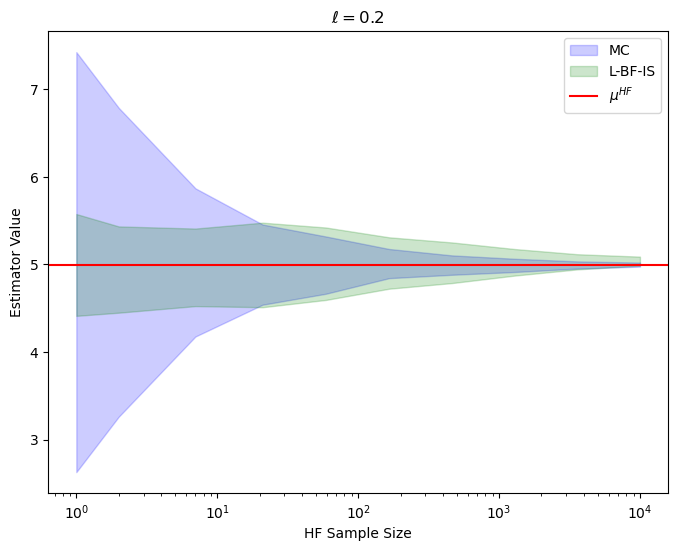

In [27]:
scale = 1.94
plt.figure(figsize=(8,6))
plt.fill_between(MC_N_lst, MC_mean-scale*MC_std, MC_mean+scale*MC_std,color='b',alpha=0.2,label='MC')
plt.fill_between(MC_N_lst, IS_mean-scale*IS_std, IS_mean+scale*IS_std,color='g',alpha=0.2,label='L-BF-IS')
plt.axhline(ExH,c='r',label=r'$\mu^{HF}$')
plt.xscale('log')
plt.xlabel('HF Sample Size')
plt.ylabel('Estimator Value')
plt.legend()
plt.title(r'$\ell=0.2$')
# plt.savefig('dim1000-l-035.pdf',format='pdf',dpi=200)